In [2]:
from pyibex import Interval, Function, IntervalVector, CtcFwdBwd
from itertools import combinations
from iodgsol import *

# Introduction

Constraint programming is a paradigm for solving combinatorial problems that can be expressed in terms of constraints on variables. When applied to distance geometry problems, it serves as a powerful tool for tackling complex issues that arise in fields such as chemistry, sensor networks, and robotics. The quintessential challenge in distance geometry is determining the Cartesian coordinates of a set of points in a space, typically three-dimensional, from a partial set of distance measurements. This type of problem is fundamental to understanding the spatial structure of molecules in bioinformatics and the coordination of robotic sensor networks among other applications.

The complexity of these problems often stems from the fact that they are not only NP-hard, meaning that no polynomial-time algorithm is known for their solution, but they are also plagued by a plethora of local minima and uncertainties. These uncertainties may arise from measurement errors or incomplete data, necessitating the use of robust algorithms that can handle inexactitudes and provide globally optimal solutions. 

This report explores the use of constraint programming to develop such algorithms, leveraging the strength of existing software packages like DGSol and exploring new methods that can improve upon them. Through a detailed comparison with the results obtained from DGSol, this study aims to highlight the efficacy of constraint programming in solving distance geometry problems and address the complexities involved in managing uncertainties in measurement.


1. **Understanding the Problem Domain:** We began by comprehensively studying distance geometry and its applications, specifically within the realms of chemistry, localization, and robotics.

2. **Literature Review:** A thorough review of the existing literature, including scholarly articles and software documentation, was conducted to understand current methodologies and tools available.

3. **Tool Acquisition:** We procured the necessary software tools, like DGSol, and familiarized ourselves with their functionality and limitations.

4. **Data Analysis:** We analyzed the data sets provided, assessing the completeness of the distance information and identifying potential inaccuracies.

5. **Algorithm Design:** Custom algorithms were designed to handle the constraint satisfaction problem (CSP), incorporating heuristics to enhance performance.

6. **Implementation:** The algorithms were implemented, and a system for reading DGSol files and converting them to our CSP format was developed.

7. **Testing and Debugging:** Rigorous testing was carried out to ensure the accuracy of our algorithms. Debugging was performed iteratively to refine our solutions.

8. **Result Visualization:** We developed mechanisms to visually represent the results of our computations for easier interpretation and comparison.

9. **Comparative Analysis:** Our results were compared with those obtained from DGSol to evaluate the effectiveness of our approach.

10. **Documentation and Reporting:** Finally, all findings and methodologies were documented in a comprehensive report, supported by visual aids and statistical analysis.



- Euclidean distance between two points $(x_1, y_1, z_1)$ and $(x_2, y_2, z_2)$ in 3D space:
$$d = \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2 + (z_2 - z_1)^2}$$



In [3]:
def build_constraints(constraints, n):
    ctc = None
    #distance constraints
    for constraint in constraints:
        point1, point2 = constraint["points"]
        f = Function("x[{}]".format(n), "y[{}]".format(n), "z[{}]".format(n), "(x[{}]-x[{}])^2+(y[{}]-y[{}])^2+(z[{}]-z[{}])^2".format(point1-1,point2-1,point1-1,point2-1,point1-1,point2-1))
        ctc_f = CtcFwdBwd(f, Interval(constraint["dmin"]**2, constraint["dmax"]**2))
        if ctc is None:
            ctc = ctc_f
        else:
            ctc = ctc & ctc_f

    # triangle inequality constraints
    for A, B, C in combinations(range(n), 3):
        # Constraint 1: AB + BC >= AC
        
        f1 = Function("x[{}]".format(n), "y[{}]".format(n), "z[{}]".format(n), 
                    "sqrt((x[{}]-x[{}])^2 + (y[{}]-y[{}])^2 + (z[{}]-z[{}])^2) + sqrt((x[{}]-x[{}])^2 + (y[{}]-y[{}])^2 + (z[{}]-z[{}])^2) - sqrt((x[{}]-x[{}])^2 + (y[{}]-y[{}])^2 + (z[{}]-z[{}])^2)".format(A, B, A, B, A, B, B, C, B, C, B, C, A, C, A, C, A, C))
        ctc_f1 = CtcFwdBwd(f1, Interval(0, float('inf')))
        ctc = ctc & ctc_f1
        # Constraint 2: AB + AC >= BC
        f2 = Function("y[{}]".format(n), "x[{}]".format(n),  "z[{}]".format(n), 
                    "sqrt((x[{}]-x[{}])^2 + (y[{}]-y[{}])^2 + (z[{}]-z[{}])^2) + sqrt((x[{}]-x[{}])^2 + (y[{}]-y[{}])^2 + (z[{}]-z[{}])^2) - sqrt((x[{}]-x[{}])^2 + (y[{}]-y[{}])^2 + (z[{}]-z[{}])^2)".format(A, B, A, B, A, B, B, C, B, C, B, C, A, C, A, C, A, C))
        ctc_f2 = CtcFwdBwd(f2, Interval(0, float('inf')))
        ctc = ctc & ctc_f2
        # Constraint 3: BC + AC >= AB
        f3 = Function("x[{}]".format(n),  "z[{}]".format(n), "y[{}]".format(n),
                    "sqrt((x[{}]-x[{}])^2 + (y[{}]-y[{}])^2 + (z[{}]-z[{}])^2) + sqrt((x[{}]-x[{}])^2 + (y[{}]-y[{}])^2 + (z[{}]-z[{}])^2) - sqrt((x[{}]-x[{}])^2 + (y[{}]-y[{}])^2 + (z[{}]-z[{}])^2)".format(A, B, A, B, A, B, B, C, B, C, B, C, A, C, A, C, A, C))
        ctc_f3 = CtcFwdBwd(f3, Interval(0, float('inf')))
        ctc = ctc & ctc_f3    
    
    # fixation cordinates of the first point
    ctc_f4 = CtcFwdBwd(Function("x[{}]".format(n), "y[{}]".format(n), "z[{}]".format(n), "x[0]"), Interval(0,0))
    ctc_f5 = CtcFwdBwd(Function("x[{}]".format(n), "y[{}]".format(n), "z[{}]".format(n), "y[0]"), Interval(0,0))
    ctc_f6 = CtcFwdBwd(Function("x[{}]".format(n), "y[{}]".format(n), "z[{}]".format(n), "z[0]"), Interval(0,0))

    ctc = ctc & ctc_f4 & ctc_f5 & ctc_f6

    # fixation line for the second point
    ctc_f7 = CtcFwdBwd(Function("x[{}]".format(n), "y[{}]".format(n), "z[{}]".format(n), "x[1]"), Interval(0,float('inf')))
    ctc_f8 = CtcFwdBwd(Function("x[{}]".format(n), "y[{}]".format(n), "z[{}]".format(n), "y[1]"), Interval(0,0))
    ctc_f9 = CtcFwdBwd(Function("x[{}]".format(n), "y[{}]".format(n), "z[{}]".format(n), "z[1]"), Interval(0,0))

    ctc = ctc & ctc_f7 & ctc_f8 & ctc_f9

    
    # fixation surface for the third point
    if n>=3:
        ctc_f10 = CtcFwdBwd(Function("x[{}]".format(n), "y[{}]".format(n), "z[{}]".format(n), "x[2]"), Interval(-float('inf'),float('inf')))
        ctc_f11 = CtcFwdBwd(Function("x[{}]".format(n), "y[{}]".format(n), "z[{}]".format(n), "y[2]"), Interval(-float('inf'),float('inf')))
        ctc_f12 = CtcFwdBwd(Function("x[{}]".format(n), "y[{}]".format(n), "z[{}]".format(n), "z[2]"), Interval(0,0))

        ctc = ctc & ctc_f10 & ctc_f11 & ctc_f12
    
    return ctc                                                              

In [4]:
def solver(initial_box, ctc, tau=0.02):
    stack = [initial_box]
    stack_acc = []
    stack_rej = []
    stack_unc = []

    while stack:
        box = stack.pop()
        original_box = box.copy()

        # Apply the contractor
        ctc.contract(box)


        # All points of the box are inside the constraints
        if (original_box == box) and (ctc.contract(box) != None):
            stack_acc.append(original_box)
        # No points of the box are inside the constraints
        elif box.is_empty():
            stack_rej.append(original_box)
        # Size of the box is big enough for further splitting
        elif box.max_diam() > tau:
            idx = max(range(len(box)), key=lambda i: box[i].diam())
            box1, box2 = box.bisect(idx)
            stack.append(box1)
            stack.append(box2)
        else:
            stack_unc.append(original_box)

    return stack_acc, stack_rej, stack_unc


In [6]:

def new_point_solver(n, box, initial_constraints, tau=0.02):
   
    box.insert(n-1,Interval(-float('inf'),float('inf')))
    box.insert(n*2-1,Interval(-float('inf'),float('inf')))
    box.append(Interval(-float('inf'),float('inf')))

    initial_box = IntervalVector(box)
    constraints = remove_constraints_with_high_id(initial_constraints, n)
    ctc = build_constraints(constraints, n)
    stack_acc, stack_rej, stack_unc = solver(initial_box, ctc, tau)
    
    return stack_acc, stack_rej, stack_unc


In [7]:

# Read the DGsol file and convert it into a list of constraints
initial_constraints = read_dgsol_file('dgsol\data\data_set_1\graph.01.data') 
print('Number of constraints: {}'.format(len(initial_constraints)))

# Find the maximum point ID in the constraints
max_id = find_max_point_id(initial_constraints)
print('Maximum point ID: {}'.format(max_id))


Number of constraints: 236
Maximum point ID: 63


In [8]:
border = 100

box = [Interval(0,0) for _ in range(3 )]

stack_acc, stack_rej, stack_unc = new_point_solver(2, box, initial_constraints, tau=0.1)

print(len(stack_acc), len(stack_rej), len(stack_unc)) 

for su in stack_unc:
    new_box = []
    for inter in su:
        new_box.append(inter)
    print(new_box)
    new_acc, new_rej, new_unc = new_point_solver(3, new_box, initial_constraints, tau=0.1)
    print(len(new_acc), len(new_rej), len(new_unc))

# for su in new_unc:
#     new_box = []
#     for inter in su:
#         new_box.append(inter)
#     print(new_box)
#     new_acc, new_rej, new_unc1 = new_point_solver(4, new_box, initial_constraints, tau=0.1)
#     print(len(new_acc), len(new_rej), len(new_unc1))


0 1 1
[[0, 0], [1.36572, 2.73144], [0, 0], [0, 0], [0, 0], [0, 0]]
0 4 6


In [9]:

n=3 
stack_unc = new_unc
constraints = remove_constraints_with_high_id(initial_constraints, n)

# n =3
# box = [Interval(-border,border) for _ in range(3*n )]
# initial_box = IntervalVector(box)

# constraints = remove_constraints_with_high_id(initial_constraints, n)

# ctc = build_constraints(constraints, n)

# stack_acc, stack_rej, stack_unc = solver(initial_box, ctc, tau=0.4)

print(len(stack_acc), len(stack_rej), len(stack_unc))

for su in stack_unc:
    cloud = []
    for i in range(n):
        cloud.append((su[i].mid(), su[n+i].mid(), su[2*n+i].mid()))
    if check_constraints(cloud, constraints):
        print("found")
        print(su)
        print(cloud)
        break
else:
    print("not found")

0 1 6
found
([0, 0] ; [2.70426, 2.73144] ; [3.50249, 3.55479] ; [0, 0] ; [0, 0] ; [2.77885, 2.84595] ; [0, 0] ; [0, 0] ; [0, 0])
[(0.0, 0.0, 0.0), (2.7178486571612037, 0.0, 0.0), (3.528641190451102, 2.8123969296085596, 0.0)]


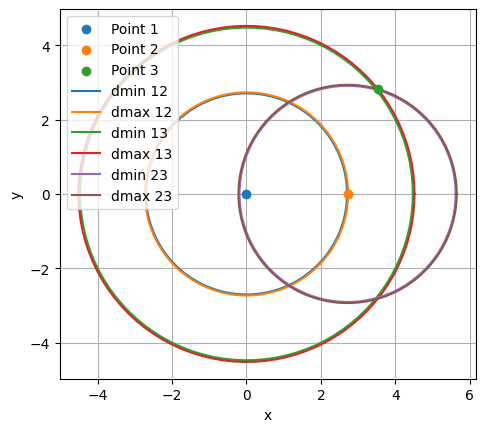

In [10]:

# plot 2D solution
if n<=3:    
    import matplotlib.pyplot as plt
    import numpy as np

    # Function to plot a circle
    def plot_circle(center, radius,  label):
        theta = np.linspace(0, 2*np.pi, 100)
        x = center[0] + radius * np.cos(theta)
        y = center[1] + radius * np.sin(theta)
        plt.plot(x, y,  label=label)

    # Function to plot a rectangle (box)
    def plot_rectangle(lower_left, upper_right, color):
        x1, y1 = lower_left
        x2, y2 = upper_right
        plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], color=color)
    # Function to plot a point
    def plot_point(point,  label):
        x, y = point
        plt.scatter(x, y,  zorder=5, label=label)

    #Plot the constraints
    for i,(x,y,z) in enumerate(cloud):
        plot_point((x,y),  label='Point {}'.format(i+1))

    for constraint in constraints:
        x,y,z = cloud[constraint["points"][0]-1]
        plot_circle((x,y), constraint["dmin"], label='dmin {}{}'.format(constraint["points"][0], constraint["points"][1]))
        plot_circle((x,y), constraint["dmax"], label='dmax {}{}'.format(constraint["points"][0], constraint["points"][1]))

    # for su in stack_unc:
    #     for i in range(1, n):
    #         x1, y1, z1 = su[3*i][0], su[3*i+1][0], su[3*i+2][0]
    #         x2, y2, z2 = su[3*i][1], su[3*i+1][1], su[3*i+2][1]
    #         plot_rectangle((x1, y1), (x2, y2), 'red')

    #Additional plot settings
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("y")

    plt.show()

# plot 3D solution
else:
    draw_3d_point_cloud(cloud)
    #draw_constraints_as_spheres(cloud, constraints)